<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#Испортипуем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,OrdinalEncoder,RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
plt.rcParams["figure.figsize"] = (8,8)
pd.set_option('display.max_rows', None)
TEST_SIZE = 0.1
#import warnings
#warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
pth1 = '/datasets/taxi.csv'
pth2 = 'C:/Users/Admin/Downloads/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1,parse_dates=['datetime'],index_col='datetime')
elif os.path.exists(pth2,parse_dates=['datetime'],index_col='datetime'):
    data_one = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
#Изучаем загруженные файлы
display(data.head(10))
print()
display(data.info(0))
print()
display(data.describe())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
#Проверяем пропуски и дубликаты
display(data.isna().sum().to_frame())
print()

,0
num_orders,0


In [6]:
#Делаем ресемплирование по одному часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [7]:
display(data.info())
print()
display(data.isna().sum())
print()
display(data.head(5))
print()
display(data.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

num_orders    0
dtype: int64

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


True

## Вывод

1. Загрузила данные.

2. Проверила пропуск. Пропусков не было.

3. Поменяла тип столбца 'datetime' int на  datetime. Столбец 'datetime' поставила как индекс датафрейма.

4. Зделала ресемплирование по часам. Построила график.

## Анализ

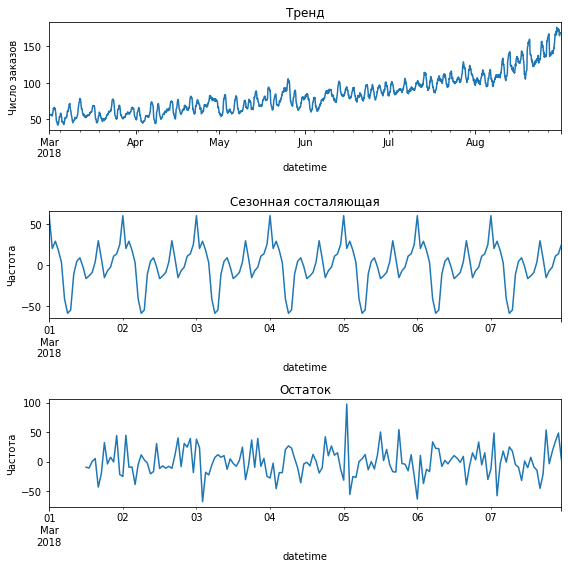

In [8]:
#Получаем график по тренду,сезонностью,остатк(15 дней)
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.ylabel('Число заказов')
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.ylabel('Частота')
plt.title('Сезонная состаляющая')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.ylabel('Частота')
plt.title('Остаток')
plt.tight_layout()

In [9]:
#Получаем скользящую среднюю
data['rolling_mean'] = data.rolling(10,closed='left').mean()

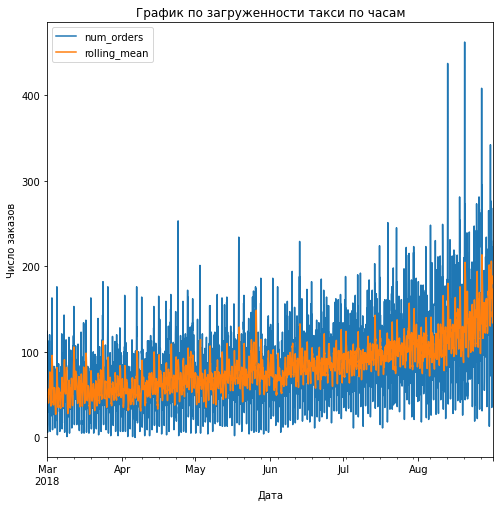

In [10]:
data.plot()
plt.title('График по загруженности такси по часам')
plt.xlabel('Дата')
plt.ylabel('Число заказов');

Тут видно что скользящая средняя растёт, ряд нестационарен. Проверим на стационарность с помощmю теста Дики-Фуллера и Квятковского-Филлипса-Шмидта-Шина (“KPSS”)

Формулирую гипотезу для теста Дики-Фуллера.

1. Нулевая гипотеза: ряд имеет единичный корень.

2. Альтернативная гипотеза: ряд не имеет единичного корня.

Если нулевую гипотезу  не удастся отвергнуть,то этот тест может предоставить доказательство того, что ряд нестационарен.

In [11]:
# Проведем тест Дики-Фуллера на стационарность
result = adfuller(data['num_orders'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


По ADF тесту p-value меньше 0.05(уровня значимости).
По тесту отвергаем нулевую гипотезу, то есть ряд стационарный.

Теперь проверим по тесту Квятковского-Филлипса-Шмидта-Шина (“KPSS”).

1. Нулевая гипотеза: процесс является стационарным по тренду.

2. Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).

Если нулевую гипотезу не удастся отвергнуть,то этот тест может предоставить доказательство того, что ряд стационарен.

In [12]:
#Проводим тест KPSS
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [13]:
kpss_test(data['num_orders'])

Results of KPSS Test:
Test Statistic           10.913353
p-value                   0.010000
Lags Used                32.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


По KPSS тесту p-value меньше 0.05(уровня значимости). По тесту  отвергаем нулевую гипотезу, то есть ряд нестационарный.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


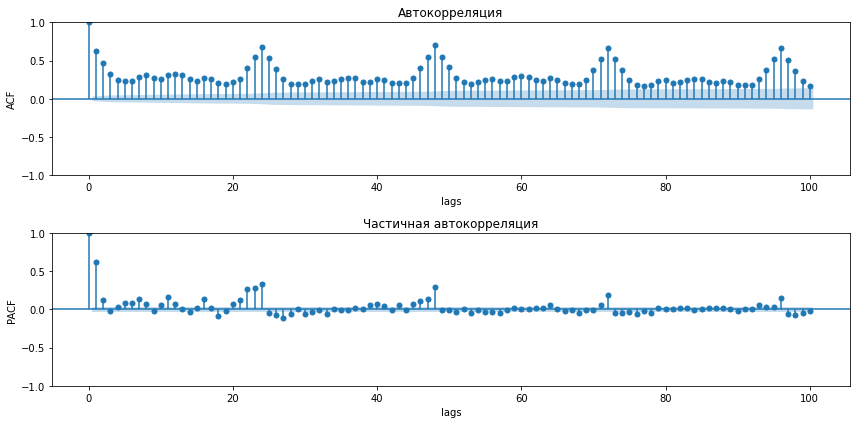

In [14]:
# Рассчитываем автокорреляцию и частичную автокорреляцию
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['num_orders'], lags=100, ax=plt.gca())
plt.ylabel('ACF')
plt.xlabel('lags')
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(data['num_orders'], lags=100, ax=plt.gca())
plt.ylabel('PACF')
plt.xlabel('lags')
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

## Вывод

1. Получила график скользящего среднего. По графику скользящая средняя растёт. Проверила на стационарность с помощью теста Дики-Фуллера и Квятковского-Филлипса-Шмидта-Шина (“KPSS”)

2. Гипотезу для теста Дики-Фуллера.

   Нулевая гипотеза: ряд имеет единичный корень.

   Альтернативная гипотеза: ряд не имеет единичного корня.

   Если нулевую гипотезу  не удастся отвергнуть,то этот тест может предоставить доказательство того, что ряд нестационарен.
   
   По ADF тесту p-value меньше 0.05(уровня значимости). По тесту отвергаем нулевую гипотезу, то есть ряд стационарный.

3. По тесту Квятковского-Филлипса-Шмидта-Шина (“KPSS”).

   Нулевая гипотеза: процесс является стационарным по тренду.

   Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).

   Если нулевую гипотезу не удастся отвергнуть,то этот тест может предоставить доказательство того, что ряд стационарен.
   
4. По итогу временоной ряд нестационарен.    

1. Получила график по тренду,сезонностью,остатк(15 дней). По тренду видно, что есть рост по заказам. 
   По сезонности видим что больше всего заказы бывают в ночное время.
   
2. По логике ночью общественный транспорт не работате. Вот по этой причине в ночное время число заказов повышаются.   

4. По ACF графику есть закономерность каждое 24 часа. То есь есть корреляция между первым и 24-ым лагом.По PACF так же.


5. Исходя из анализа, для обучения получу признаки день,часы и день недели.

## Обучение

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_make_features = data.copy()
    data_make_features['day'] = data_make_features.index.day
    data_make_features['hour'] = data_make_features.index.hour
    data_make_features['dayofweek'] = data_make_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_make_features['lag_{}'.format(lag)] = data_make_features['num_orders'].shift(lag)
    
    data_make_features['rolling_mean'] = data_make_features['num_orders'].shift().rolling(rolling_mean_size).mean()    
    return data_make_features.dropna()
    
data_new =  make_features(data,24,24)



In [16]:
data_new.head(10)

,num_orders,rolling_mean,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,56.833333,2,0,4,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,55.416667,2,1,4,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,56.875000,2,2,4,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,57.041667,2,3,4,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,56.958333,2,4,4,64.0,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
2018-03-02 05:00:00,11,56.000000,2,5,4,20.0,64.0,75.0,120.0,90.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0
2018-03-02 06:00:00,11,56.208333,2,6,4,11.0,20.0,64.0,75.0,120.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0
2018-03-02 07:00:00,7,56.166667,2,7,4,11.0,11.0,20.0,64.0,75.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0
2018-03-02 08:00:00,46,55.833333,2,8,4,7.0,11.0,11.0,20.0,64.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0


In [17]:
#Разбиваем данные на трен. и тест. выборки
train,test = train_test_split(data_new,test_size=TEST_SIZE,shuffle=False)
train = train.dropna()


train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'],axis=1)
test_target = test['num_orders']

print(train_features.shape,train_target.shape,test_features.shape,test_target.shape)

(3952, 28) (3952,) (440, 28) (440,)


In [18]:
%%time
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([('models', LinearRegression())])

pipe_final

CPU times: user 64 µs, sys: 34 µs, total: 98 µs
Wall time: 102 µs


Pipeline(steps=[('models', LinearRegression())])

In [19]:
%%time
# словарь для моделей
param_grid = [
             
              {'models': [LinearRegression()]
               },
  
             {'models': [DecisionTreeRegressor(random_state=42)]
               ,'models__max_depth': list(range(6,10))
               ,'models__max_features': list(range(2,8))
               },
    
             {'models' : [LGBMRegressor()],
              'models__max_depth': list(range(5, 8, 10)),
              'models__n_estimators': list(range(100,120,140)),
              'models__learning_rate': list(range(1,5,10)),
              },
            
            {'models': [RandomForestRegressor(random_state=42)],
               'models__n_estimators': list(range(50,80,100)),
               'models__max_features': ['sqrt', 'log2'],
               'models__max_leaf_nodes': list(range(10,18)),
               'models__max_depth': (None, *range(12,14,16)),
               }
            ]

param_grid

CPU times: user 57 µs, sys: 30 µs, total: 87 µs
Wall time: 90.8 µs


[{'models': [LinearRegression()]},
 {'models': [DecisionTreeRegressor(random_state=42)],
  'models__max_depth': [6, 7, 8, 9],
  'models__max_features': [2, 3, 4, 5, 6, 7]},
 {'models': [LGBMRegressor()],
  'models__max_depth': [5],
  'models__n_estimators': [100],
  'models__learning_rate': [1]},
 {'models': [RandomForestRegressor(random_state=42)],
  'models__n_estimators': [50],
  'models__max_features': ['sqrt', 'log2'],
  'models__max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17],
  'models__max_depth': (None, 12)}]

In [20]:
%%time
#Обучаем тренировочные выборки
pipe_final.fit(train_features, train_target)

CPU times: user 5.2 ms, sys: 6.62 ms, total: 11.8 ms
Wall time: 5.44 ms


Pipeline(steps=[('models', LinearRegression())])

In [21]:
%%time
#Испльзуем RandomizedSearchCV для поиска лучших параметров
randomized_search = RandomizedSearchCV(pipe_final, param_distributions=param_grid, cv=TimeSeriesSplit(n_splits=5),
                                       scoring='neg_root_mean_squared_error',random_state=42
                                       ,n_jobs=-1, error_score='raise')

CPU times: user 190 µs, sys: 101 µs, total: 291 µs
Wall time: 52.5 µs


In [22]:
randomized_search

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()]},
                                        {'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': [6, 7, 8, 9],
                                         'models__max_features': [2, 3, 4, 5, 6,
                                                                  7]},
                                        {'models': [LGBMRegressor()],
                                         'models__learning_rate': [1],
                                         'models__max_depth': [5],
                                         'models__n_estimators': [100]},
                                        {'models': [RandomForestRegressor(random

In [23]:
%%time
#Обучаем модель по полученным данным


randomized_search.fit(train_features, train_target)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print (f'Метрика лучшей модели на тренировочной выборке:, {round(-(randomized_search.best_score_),1)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('models', LinearRegression())])
Метрика лучшей модели на тренировочной выборке:, 27.2
CPU times: user 6.96 s, sys: 594 ms, total: 7.56 s
Wall time: 7.56 s


## Вывод 

1. С помощью функции make_features создала признаки для обучения.

2. Разделиле датасет на трейн. и тест ваборки.

3. Создала пайплайн с разными моделями.

4. Использовала RandomizedSearchCV(кросс валидация) получила лучшую модель и RMSE для этой модели на трен. данных. 
   
   RandomForestRegressor(max_features='log2', max_leaf_nodes=16))])
   
   Метрика лучшей модели на тренировочной выборке:, 27.3
   
   Время работы 9.36сек.

## Тестирование

In [24]:
%%time
# В best_model будет храниться наш пайплайн
best_model = randomized_search.best_estimator_
rf_model = best_model.named_steps['models']
rf_model

CPU times: user 163 µs, sys: 39 µs, total: 202 µs
Wall time: 33.4 µs


LinearRegression()

In [25]:
%%time
#Предсказываем на тестовх данных
prediction = rf_model.predict(test_features)

CPU times: user 2.87 ms, sys: 707 µs, total: 3.58 ms
Wall time: 1.95 ms


In [26]:
%%time
#Получаем оценку метрик
rmse = mean_squared_error(test_target, prediction) ** 0.5
round(rmse,1)

CPU times: user 0 ns, sys: 7.02 ms, total: 7.02 ms
Wall time: 997 µs


45.2

## Вывод

1. Сохранила лучшую модель в переменной <a id='the_destination'>rf_model</a>

2. Сделала предсказания на тестовых данных <a id='the_destination'>rmse = 45.8</a>, время работы 771мс

In [27]:
#Проверяем качество прогноза
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = test_target.iloc[-1]
rmse_prev = mean_squared_error(test_target, pred_previous) ** 0.5
round(rmse,1)


45.2

Получили такой же результат что и на тестовых данных.

## Общий вывод

1. Загрузила данные.

2. Проверила пропуск. Пропусков не было.

3. Поменяла тип столбца 'datetime' int на  datetime. Столбец 'datetime' поставила как индекс датафрейма.

4. Зделала ресемплирование по часам. Построила график.

5. Получила график скользящего среднего. По графику скользящая средняя растёт. Проверила на стационарность с помощью теста Дики-Фуллера и Квятковского-Филлипса-Шмидта-Шина    (“KPSS”)

   1. Гипотезу для теста Дики-Фуллера.

      Нулевая гипотеза: ряд имеет единичный корень.

      Альтернативная гипотеза: ряд не имеет единичного корня.

      Если нулевую гипотезу  не удастся отвергнуть,то этот тест может предоставить доказательство того, что ряд нестационарен.
   
      По ADF тесту p-value меньше 0.05(уровня значимости). По тесту отвергаем нулевую гипотезу, то есть ряд стационарный.

   2. По тесту Квятковского-Филлипса-Шмидта-Шина (“KPSS”).

      Нулевая гипотеза: процесс является стационарным по тренду.

      Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).

      Если нулевую гипотезу не удастся отвергнуть,то этот тест может предоставить доказательство того, что ряд стационарен.
   
   3. По итогу временоной ряд нестационарен.    
7. Получила график по тренду,сезонностью,остатк(15 дней). По тренду видно, что есть рост по заказам. По сезонности видим что больше всего заказы бывают в начное время.

8. По ACF графику есть закономерность каждое 24 часа. То есь есть корреляция между первым и 24-ым лагом.По PACF так же.

9. Исходя из анализа, для обучения получу признаки месяц,день,часы и день недели.

10. С помощью функции make_features создала признаки для обучения.

11. Разделиле датасет на трейн. и тест ваборки.

12. Создала пайплайн с разными моделями.

13. Использовала RandomizedSearchCV(кросс валидация) получила лучшую модель и RMSE для этой модели на трен. данных.

    RandomForestRegressor(max_features='log2', max_leaf_nodes=16))])

    Метрика лучшей модели на тренировочной выборке:, 27.3

    Время работы 9.36сек.

14. Сохранила лучшую модель в переменной rf_model

15. Сделала предсказания на тестовых данных rmse = 45.8, время работы 771мс